In [1]:
import sys
import os.path
import numpy as np
import tensorflow as tf
import keras
import xarray as xr
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.layers import ConvLSTM2D, BatchNormalization, MaxPooling3D, TimeDistributed, Flatten, Dense, concatenate
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.utils.layer_utils import count_params

from parflow_nn.losses import log_loss, rmse, var_loss, var_ratio, metrics
from parflow_nn.preprocess_PF import create_feature_or_target_da
from parflow_nn.write_nc import generate_nc_files
from parflow_nn.config import Config
from cond_rnn import ConditionalRNN2D
from tensorflow.python.client import device_lib


Using TensorFlow backend.


In [2]:
# Normalization
def normalize_feature_da(feature_da, feature_names=None):
    """Normalize feature arrays, and optionally target array
    Args:
        feature_da: feature Dataset
        feature_names: Feature name strings
    Returns:
        da: Normalized DataArray
    """
    if feature_names is not None: # static inputs
        con_stats_norm = []
        for feati in feature_da:
            if len(np.unique(feati)) == 1:
                con_stats_norm.append(feati)
            else:
                meani = np.ma.mean(feati, axis = (2, 3))
                stdi = np.ma.std(feati, axis = (2, 3))
                meani[stdi == 0] = 0
                stdi[stdi == 0] = 1
                #broadcast back stdi
                stdi_broadcast = np.tile(stdi, (1, feati.shape[2], feati.shape[3], 1))
                stdi_broadcast = np.swapaxes(stdi_broadcast, 2, 3)
                stdi_broadcast = np.swapaxes(stdi_broadcast, 1, 2)
                #broadcast back meani
                meani_broadcast = np.tile(meani, (1, feati.shape[2], feati.shape[3], 1))
                meani_broadcast = np.swapaxes(meani_broadcast, 2, 3)
                meani_broadcast = np.swapaxes(meani_broadcast, 1, 2)
                feati_norm = (feati - meani_broadcast) / stdi_broadcast
                con_stats_norm.append(feati_norm)
        return con_stats_norm
    else: # forcing inputs and target
        forcing_mean = np.ma.mean(feature_da, axis = (0, 1, 2, 3))
        forcing_std = np.ma.std(feature_da, axis = (0, 1, 2, 3))
        forcing_mean[forcing_std == 0] = 0
        forcing_std[forcing_std == 0] = 1
        #broadcast back
        mean_broadcast = np.tile(forcing_mean, (1, feature_da.shape[1], feature_da.shape[2],
                                feature_da.shape[3], 1))
        std_broadcast = np.tile(forcing_std, (1, feature_da.shape[1], feature_da.shape[2],
                                feature_da.shape[3], 1))
        return (feature_da - mean_broadcast) / std_broadcast


In [3]:
device_lib.list_local_devices()

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [4]:
run_name, out_dir, is_clm = 'washita_clm', '/glade/scratch/hoangtran/ParFlow-NN/nc_files', True

static_file = os.path.join(out_dir, f'{run_name}_static.nc')
forcing_file = os.path.join(out_dir, f'{run_name}_forcings.nc')
target_satur_file = os.path.join(out_dir, f'{run_name}_satur.nc')
target_press_file = os.path.join(out_dir, f'{run_name}_press.nc')

if is_clm:
    target_clm_file = os.path.join(out_dir, f'{run_name}_clm.nc')


In [5]:
# Forcing data
forcing_input = xr.open_dataset(forcing_file)

forcing_feature_da, forcing_feature_names = create_feature_or_target_da(
    forcing_input,
    ['forcings'],
    0,
    'feature',
    flx_same_dt=True
)

# Add channel dimension
if is_clm:
    forcing_feature_da = forcing_feature_da.data[:]
    forcing_feature_da = np.swapaxes(forcing_feature_da, 1, 2)
    forcing_feature_da = np.swapaxes(forcing_feature_da, 2, 3)
    forcing_feature_da = np.repeat(forcing_feature_da,
                           repeats=[2] + [1] * (forcing_feature_da.shape[0] - 1),
                           axis=0)  # duplicate the first row
    forcing_feature_da = forcing_feature_da[np.newaxis, ...]
else:
    forcing_feature_da = forcing_feature_da.data[:, 0, :, :]
    forcing_feature_da = forcing_feature_da[..., np.newaxis]
    forcing_feature_da = forcing_feature_da[np.newaxis, ...]


In [6]:
# Static inputs
static_input_xr = xr.open_dataset(static_file)

con_stats = []
con_stat_names = []
for var in static_input_xr.data_vars:
    tmp_stat = static_input_xr[var].data
    if var in ['slope_x', 'slope_y', 'spec_storage', 'mannings', 'tensor_x', 'tensor_y', 'tensor_z']:
        tmp_stat = tmp_stat[:, -1, :, :]
        tmp_stat = tmp_stat[np.newaxis, ...]
        tmp_stat = np.swapaxes(tmp_stat, 0, 1)
    con_stat_names.append(var)
    con_stats.append(tmp_stat)


In [7]:
# Target outputs
target_press_input_xr = xr.open_dataset(target_press_file)
target_satur_input_xr = xr.open_dataset(target_satur_file)
if is_clm:
    target_clm_input_xr = xr.open_dataset(target_clm_file)
    target_clm = np.repeat(target_clm_input_xr.clm,
                           repeats=[2]+[1]*(target_clm_input_xr.clm.shape[0] - 1),
                           axis=0) #duplicate the first row
    target_da = np.concatenate([target_press_input_xr.press,
                        target_satur_input_xr.satur,
                        target_clm], axis = 1)
    target_da = target_da[np.newaxis, ...]
else:
    target_dataset = target_press_input_xr.merge(target_satur_input_xr)
    target_da, target_names = create_feature_or_target_da(
        target_dataset,
        ['press', 'satur'],
        0,
        'target',
        1,
        flx_same_dt=True
    )

    target_da = target_da.data[np.newaxis, ...]

target_da = np.swapaxes(target_da, 2, 3)
target_da = np.swapaxes(target_da, 3, 4)


In [8]:
Filters1 = 16
Filters2 = [32, 64, 128, 256, 256, 256, 256, 123]
Kernels1 = 3
Kernels2 = [3, 3, 3, 3, 3, 3, 3, 3]

file_path = '/glade/scratch/hoangtran/new_model.h5'

In [18]:
forcing_feature_train = forcing_feature_da[:, :24, :, :, :]
target_train = target_da[:, :24, :, :, :]



In [19]:
n_sample, n_time, n_lat, n_lon, n_vars = forcing_feature_train.shape

In [20]:
#Normalization
con_stats_norm = normalize_feature_da(con_stats, con_stat_names)
forcing_norm_train = normalize_feature_da(forcing_feature_train)
target_norm_train = normalize_feature_da(target_train)

In [12]:
def build_mobilenet(shape, trainable):
    model = tf.keras.Sequential()
    if shape[2] != 3:
        model.add(tf.keras.layers.Conv2D(3, 3, padding = 'same'))
        shape = (shape[0], shape[1], 3)
    
    pre_train_model = tf.keras.applications.mobilenet.MobileNet(include_top = False,
                                                                input_shape = shape,
                                                               weights = 'imagenet')
    # Keep 6 layers to train
    for layer in pre_train_model.layers[:-trainable]:
        pre_train_model.trainable = False
    for layer in pre_train_model.layers[-trainable:]:
        pre_train_model.trainable = True
    
    model.add(pre_train_model)
    model.add(tf.keras.layers.GlobalMaxPool2D())
    return model

In [44]:
def final_model(shape, nclass, kernel, trainable = 6):
    convnet = build_mobilenet(shape[1:], trainable)

    model = tf.keras.Sequential()
    model.add(tf.keras.layers.TimeDistributed(convnet, input_shape = shape))
    model.add(tf.keras.layers.Dense(n_lat * n_lon))
    model.add(tf.keras.layers.Reshape((n_time, n_lat, n_lon, 1)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.ConvLSTM2D(filters = 16, kernel_size = kernel,
                                           data_format='channels_last',
                                           recurrent_activation='hard_sigmoid',
                                           activation='tanh',
                                           padding='same', return_sequences=True))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.ConvLSTM2D(filters = 24, kernel_size = kernel,
                                           data_format='channels_last',
                                           recurrent_activation='hard_sigmoid',
                                           activation='tanh',
                                           padding='same', return_sequences=True))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.ConvLSTM2D(filters = 48, kernel_size = kernel,
                                           data_format='channels_last',
                                           recurrent_activation='hard_sigmoid',
                                           activation='tanh',
                                           padding='same', return_sequences=True))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.ConvLSTM2D(filters = 96, kernel_size = kernel,
                                           data_format='channels_last',
                                           recurrent_activation='hard_sigmoid',
                                           activation='tanh',
                                           padding='same', return_sequences=True))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.ConvLSTM2D(filters = 128, kernel_size = kernel,
                                           data_format='channels_last',
                                           recurrent_activation='hard_sigmoid',
                                           activation='tanh',
                                           padding='same', return_sequences=True))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.ConvLSTM2D(filters = 128, kernel_size = kernel,
                                           data_format='channels_last',
                                           recurrent_activation='hard_sigmoid',
                                           activation='tanh',
                                           padding='same', return_sequences=True))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.ConvLSTM2D(filters = 128, kernel_size = kernel,
                                           data_format='channels_last',
                                           recurrent_activation='hard_sigmoid',
                                           activation='tanh',
                                           padding='same', return_sequences=True))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.ConvLSTM2D(filters = 128, kernel_size = kernel,
                                           data_format='channels_last',
                                           recurrent_activation='hard_sigmoid',
                                           activation='tanh',
                                           padding='same', return_sequences=True))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.ConvLSTM2D(filters = 128, kernel_size = kernel,
                                           data_format='channels_last',
                                           recurrent_activation='hard_sigmoid',
                                           activation='tanh',
                                           padding='same', return_sequences=True))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.ConvLSTM2D(filters = 128, kernel_size = kernel,
                                           data_format='channels_last',
                                           recurrent_activation='hard_sigmoid',
                                           activation='tanh',
                                           padding='same', return_sequences=True))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.ConvLSTM2D(filters = nclass, kernel_size = kernel,
                                           data_format='channels_last',
                                           recurrent_activation='hard_sigmoid',
                                           activation='tanh',
                                           padding='same', return_sequences=True))
    return model

In [45]:
shape = (n_time, n_lat, n_lon, n_vars)
nclass = 123
kernel = 3

In [46]:
model = final_model(shape, nclass, kernel)
optimizer = tf.keras.optimizers.RMSprop(learning_rate = 1e-4)
model.call([forcing_norm_train])

/glade/work/hoangtran/my_npl_clone_casper/lib/python3.7/site-packages/keras_applications/mobilenet.py:207: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '



If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



<tf.Tensor: id=938736, shape=(1, 24, 41, 41, 123), dtype=float32, numpy=
array([[[[[ 6.11050056e-12, -5.69741650e-12,  7.61245667e-12, ...,
            3.65605593e-12,  2.87253945e-12, -4.57766507e-12],
          [ 1.73060923e-11, -2.18267245e-12,  1.77569574e-11, ...,
            8.00929895e-12, -9.79428951e-12,  2.55043209e-12],
          [ 2.12491916e-13,  1.12246653e-11, -1.18348482e-11, ...,
            2.25298582e-11, -1.22211512e-11, -1.06607761e-11],
          ...,
          [ 1.43669208e-11, -2.82300073e-12,  1.93059561e-11, ...,
            2.69223359e-12,  1.00263096e-11,  3.43405200e-11],
          [ 8.23949589e-12, -1.33712347e-11,  1.93298069e-12, ...,
            1.39639984e-11, -2.46151086e-11,  9.35162364e-12],
          [-2.77196495e-12, -5.38477856e-12,  5.64337119e-12, ...,
           -1.07380511e-12, -5.24597726e-12, -4.36595118e-12]],

         [[ 4.67271014e-12,  7.22591258e-12,  6.84247450e-12, ...,
           -9.07450677e-12, -1.22449897e-11, -2.62648106e-12],


In [48]:
model = final_model(shape, nclass, kernel)
optimizer = tf.keras.optimizers.RMSprop(learning_rate = 1e-4)
model.call([forcing_norm_train])
model.compile(optimizer = optimizer, loss = 'mse', metrics = ['mse'])

checkpoint = ModelCheckpoint(file_path, monitor='loss', verbose=1, save_best_only=True, mode='min',
                            save_weights_only=False)
callbacks_list = [checkpoint]
model.fit(x = [forcing_norm_train], y = target_norm_train, epochs = 500,
         batch_size = 64, callbacks = callbacks_list)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Train on 1 samples
Epoch 1/500

Epoch 00001: loss improved from inf to 1.05659, saving model to /glade/scratch/hoangtran/new_model.h5
1/1 [==============================] - 40s 40s/sample - loss: 1.0566 - mse: 1.0566
Epoch 2/500

Epoch 00002: loss improved from 1.05659 to 1.02992, saving model to /glade/scratch/hoangtran/new_model.h5
1/1 [==============================] - 1s 975ms/sample - loss: 1.0299 - mse: 1.0299
Epoch 3/500

Epoch 00003: loss improved from 1.02992 to 0.98424, saving model to /glade/

Epoch 40/500

Epoch 00040: loss improved from 0.38874 to 0.38757, saving model to /glade/scratch/hoangtran/new_model.h5
1/1 [==============================] - 1s 943ms/sample - loss: 0.3876 - mse: 0.3876
Epoch 41/500

Epoch 00041: loss did not improve from 0.38757
1/1 [==============================] - 1s 645ms/sample - loss: 0.3956 - mse: 0.3956
Epoch 42/500

Epoch 00042: loss did not improve from 0.38757
1/1 [==============================] - 1s 638ms/sample - loss: 0.4017 - mse: 0.4017
Epoch 43/500

Epoch 00043: loss did not improve from 0.38757
1/1 [==============================] - 1s 660ms/sample - loss: 0.3973 - mse: 0.3973
Epoch 44/500

Epoch 00044: loss improved from 0.38757 to 0.38058, saving model to /glade/scratch/hoangtran/new_model.h5
1/1 [==============================] - 1s 954ms/sample - loss: 0.3806 - mse: 0.3806
Epoch 45/500

Epoch 00045: loss improved from 0.38058 to 0.36910, saving model to /glade/scratch/hoangtran/new_model.h5
1/1 [==============================] 

Epoch 87/500

Epoch 00087: loss improved from 0.27794 to 0.27604, saving model to /glade/scratch/hoangtran/new_model.h5
1/1 [==============================] - 1s 941ms/sample - loss: 0.2760 - mse: 0.2760
Epoch 88/500

Epoch 00088: loss did not improve from 0.27604
1/1 [==============================] - 1s 637ms/sample - loss: 0.2793 - mse: 0.2793
Epoch 89/500

Epoch 00089: loss did not improve from 0.27604
1/1 [==============================] - 1s 637ms/sample - loss: 0.2835 - mse: 0.2835
Epoch 90/500

Epoch 00090: loss did not improve from 0.27604
1/1 [==============================] - 1s 639ms/sample - loss: 0.2849 - mse: 0.2849
Epoch 91/500

Epoch 00091: loss did not improve from 0.27604
1/1 [==============================] - 1s 636ms/sample - loss: 0.2944 - mse: 0.2944
Epoch 92/500

Epoch 00092: loss did not improve from 0.27604
1/1 [==============================] - 1s 632ms/sample - loss: 0.2884 - mse: 0.2884
Epoch 93/500

Epoch 00093: loss did not improve from 0.27604
1/1 [=====

Epoch 138/500

Epoch 00138: loss did not improve from 0.23765
1/1 [==============================] - 1s 643ms/sample - loss: 0.2453 - mse: 0.2453
Epoch 139/500

Epoch 00139: loss did not improve from 0.23765
1/1 [==============================] - 1s 644ms/sample - loss: 0.2379 - mse: 0.2379
Epoch 140/500

Epoch 00140: loss did not improve from 0.23765
1/1 [==============================] - 1s 645ms/sample - loss: 0.2381 - mse: 0.2381
Epoch 141/500

Epoch 00141: loss did not improve from 0.23765
1/1 [==============================] - 1s 647ms/sample - loss: 0.2400 - mse: 0.2400
Epoch 142/500

Epoch 00142: loss did not improve from 0.23765
1/1 [==============================] - 1s 642ms/sample - loss: 0.2474 - mse: 0.2474
Epoch 143/500

Epoch 00143: loss did not improve from 0.23765
1/1 [==============================] - 1s 639ms/sample - loss: 0.2427 - mse: 0.2427
Epoch 144/500

Epoch 00144: loss improved from 0.23765 to 0.23721, saving model to /glade/scratch/hoangtran/new_model.h5
1/1

Epoch 190/500

Epoch 00190: loss did not improve from 0.21750
1/1 [==============================] - 1s 642ms/sample - loss: 0.2176 - mse: 0.2176
Epoch 191/500

Epoch 00191: loss improved from 0.21750 to 0.21710, saving model to /glade/scratch/hoangtran/new_model.h5
1/1 [==============================] - 1s 950ms/sample - loss: 0.2171 - mse: 0.2171
Epoch 192/500

Epoch 00192: loss did not improve from 0.21710
1/1 [==============================] - 1s 645ms/sample - loss: 0.2196 - mse: 0.2196
Epoch 193/500

Epoch 00193: loss did not improve from 0.21710
1/1 [==============================] - 1s 642ms/sample - loss: 0.2275 - mse: 0.2275
Epoch 194/500

Epoch 00194: loss did not improve from 0.21710
1/1 [==============================] - 1s 637ms/sample - loss: 0.2229 - mse: 0.2229
Epoch 195/500

Epoch 00195: loss did not improve from 0.21710
1/1 [==============================] - 1s 641ms/sample - loss: 0.2193 - mse: 0.2193
Epoch 196/500

Epoch 00196: loss improved from 0.21710 to 0.21658

Epoch 242/500

Epoch 00242: loss did not improve from 0.20530
1/1 [==============================] - 1s 642ms/sample - loss: 0.2085 - mse: 0.2085
Epoch 243/500

Epoch 00243: loss did not improve from 0.20530
1/1 [==============================] - 1s 644ms/sample - loss: 0.2099 - mse: 0.2099
Epoch 244/500

Epoch 00244: loss did not improve from 0.20530
1/1 [==============================] - 1s 642ms/sample - loss: 0.2106 - mse: 0.2106
Epoch 245/500

Epoch 00245: loss did not improve from 0.20530
1/1 [==============================] - 1s 666ms/sample - loss: 0.2116 - mse: 0.2116
Epoch 246/500

Epoch 00246: loss did not improve from 0.20530
1/1 [==============================] - 1s 656ms/sample - loss: 0.2081 - mse: 0.2081
Epoch 247/500

Epoch 00247: loss did not improve from 0.20530
1/1 [==============================] - 1s 657ms/sample - loss: 0.2076 - mse: 0.2076
Epoch 248/500

Epoch 00248: loss did not improve from 0.20530
1/1 [==============================] - 1s 669ms/sample - loss:


Epoch 00294: loss did not improve from 0.19923
1/1 [==============================] - 1s 643ms/sample - loss: 0.2055 - mse: 0.2055
Epoch 295/500

Epoch 00295: loss did not improve from 0.19923
1/1 [==============================] - 1s 652ms/sample - loss: 0.2053 - mse: 0.2053
Epoch 296/500

Epoch 00296: loss did not improve from 0.19923
1/1 [==============================] - 1s 643ms/sample - loss: 0.2046 - mse: 0.2046
Epoch 297/500

Epoch 00297: loss did not improve from 0.19923
1/1 [==============================] - 1s 642ms/sample - loss: 0.2016 - mse: 0.2016
Epoch 298/500

Epoch 00298: loss did not improve from 0.19923
1/1 [==============================] - 1s 640ms/sample - loss: 0.2001 - mse: 0.2001
Epoch 299/500

Epoch 00299: loss did not improve from 0.19923
1/1 [==============================] - 1s 638ms/sample - loss: 0.2002 - mse: 0.2002
Epoch 300/500

Epoch 00300: loss did not improve from 0.19923
1/1 [==============================] - 1s 639ms/sample - loss: 0.2009 - mse:

Epoch 349/500

Epoch 00349: loss improved from 0.19757 to 0.19713, saving model to /glade/scratch/hoangtran/new_model.h5
1/1 [==============================] - 1s 952ms/sample - loss: 0.1971 - mse: 0.1971
Epoch 350/500

Epoch 00350: loss improved from 0.19713 to 0.19683, saving model to /glade/scratch/hoangtran/new_model.h5
1/1 [==============================] - 1s 946ms/sample - loss: 0.1968 - mse: 0.1968
Epoch 351/500

Epoch 00351: loss did not improve from 0.19683
1/1 [==============================] - 1s 641ms/sample - loss: 0.1971 - mse: 0.1971
Epoch 352/500

Epoch 00352: loss did not improve from 0.19683
1/1 [==============================] - 1s 643ms/sample - loss: 0.1969 - mse: 0.1969
Epoch 353/500

Epoch 00353: loss did not improve from 0.19683
1/1 [==============================] - 1s 636ms/sample - loss: 0.1974 - mse: 0.1974
Epoch 354/500

Epoch 00354: loss did not improve from 0.19683
1/1 [==============================] - 1s 648ms/sample - loss: 0.1974 - mse: 0.1974
Epoch 

Epoch 402/500

Epoch 00402: loss did not improve from 0.19356
1/1 [==============================] - 1s 646ms/sample - loss: 0.1958 - mse: 0.1958
Epoch 403/500

Epoch 00403: loss did not improve from 0.19356
1/1 [==============================] - 1s 643ms/sample - loss: 0.1948 - mse: 0.1948
Epoch 404/500

Epoch 00404: loss did not improve from 0.19356
1/1 [==============================] - 1s 644ms/sample - loss: 0.1939 - mse: 0.1939
Epoch 405/500

Epoch 00405: loss did not improve from 0.19356
1/1 [==============================] - 1s 643ms/sample - loss: 0.1936 - mse: 0.1936
Epoch 406/500

Epoch 00406: loss improved from 0.19356 to 0.19343, saving model to /glade/scratch/hoangtran/new_model.h5
1/1 [==============================] - 1s 983ms/sample - loss: 0.1934 - mse: 0.1934
Epoch 407/500

Epoch 00407: loss improved from 0.19343 to 0.19323, saving model to /glade/scratch/hoangtran/new_model.h5
1/1 [==============================] - 1s 946ms/sample - loss: 0.1932 - mse: 0.1932
Epoch 

Epoch 455/500

Epoch 00455: loss did not improve from 0.19148
1/1 [==============================] - 1s 652ms/sample - loss: 0.1923 - mse: 0.1923
Epoch 456/500

Epoch 00456: loss did not improve from 0.19148
1/1 [==============================] - 1s 652ms/sample - loss: 0.1936 - mse: 0.1936
Epoch 457/500

Epoch 00457: loss did not improve from 0.19148
1/1 [==============================] - 1s 671ms/sample - loss: 0.1954 - mse: 0.1954
Epoch 458/500

Epoch 00458: loss did not improve from 0.19148
1/1 [==============================] - 1s 650ms/sample - loss: 0.1948 - mse: 0.1948
Epoch 459/500

Epoch 00459: loss did not improve from 0.19148
1/1 [==============================] - 1s 665ms/sample - loss: 0.1949 - mse: 0.1949
Epoch 460/500

Epoch 00460: loss did not improve from 0.19148
1/1 [==============================] - 1s 663ms/sample - loss: 0.1934 - mse: 0.1934
Epoch 461/500

Epoch 00461: loss did not improve from 0.19148
1/1 [==============================] - 1s 655ms/sample - loss:

In [49]:
new_model = final_model(shape, nclass, kernel)
optimizer = tf.keras.optimizers.RMSprop(learning_rate = 1e-5)
new_model.call([forcing_norm_train])
new_model.compile(optimizer = optimizer, loss = 'mse', metrics = ['mse'])
new_model.load_weights(file_path)
# fit the model"
checkpoint = ModelCheckpoint(file_path, monitor='loss',verbose=1, save_best_only=True, mode='min',
                            save_weights_only=False)
callbacks_list = [checkpoint]
new_model.fit(x = [forcing_norm_train], y = target_norm_train, epochs = 500,
         batch_size = 64, callbacks = callbacks_list)

/glade/work/hoangtran/my_npl_clone_casper/lib/python3.7/site-packages/keras_applications/mobilenet.py:207: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '



If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Train on 1 samples
Epoch 1/500

Epoch 00001: loss improved from inf to 0.19121, saving model to /glade/scratch/hoangtran/new_model.h5
1/1 [==============================] - 35s 35s/sample - loss: 0.1912 - mse: 0.1912
Epoch 2/500

Epoch 00002: loss improved from 0.19121 to 0.18988, saving model to /glade/scratch/hoangtran/new_model.h5
1/1 [==============================] - 1s 987ms/sample - loss: 0.1899 - mse: 0.1899
Epoch 3/500

Epoch 00003: loss improved from 0.18988 to 0.18971, saving model to /glade/

Epoch 38/500

Epoch 00038: loss improved from 0.18914 to 0.18913, saving model to /glade/scratch/hoangtran/new_model.h5
1/1 [==============================] - 1s 987ms/sample - loss: 0.1891 - mse: 0.1891
Epoch 39/500

Epoch 00039: loss improved from 0.18913 to 0.18912, saving model to /glade/scratch/hoangtran/new_model.h5
1/1 [==============================] - 1s 982ms/sample - loss: 0.1891 - mse: 0.1891
Epoch 40/500

Epoch 00040: loss improved from 0.18912 to 0.18911, saving model to /glade/scratch/hoangtran/new_model.h5
1/1 [==============================] - 1s 1s/sample - loss: 0.1891 - mse: 0.1891
Epoch 41/500

Epoch 00041: loss improved from 0.18911 to 0.18910, saving model to /glade/scratch/hoangtran/new_model.h5
1/1 [==============================] - 1s 957ms/sample - loss: 0.1891 - mse: 0.1891
Epoch 42/500

Epoch 00042: loss improved from 0.18910 to 0.18909, saving model to /glade/scratch/hoangtran/new_model.h5
1/1 [==============================] - 1s 962ms/sample - loss: 0.18

1/1 [==============================] - 1s 964ms/sample - loss: 0.1887 - mse: 0.1887
Epoch 79/500

Epoch 00079: loss improved from 0.18875 to 0.18874, saving model to /glade/scratch/hoangtran/new_model.h5
1/1 [==============================] - 1s 986ms/sample - loss: 0.1887 - mse: 0.1887
Epoch 80/500

Epoch 00080: loss improved from 0.18874 to 0.18874, saving model to /glade/scratch/hoangtran/new_model.h5
1/1 [==============================] - 1s 973ms/sample - loss: 0.1887 - mse: 0.1887
Epoch 81/500

Epoch 00081: loss improved from 0.18874 to 0.18874, saving model to /glade/scratch/hoangtran/new_model.h5
1/1 [==============================] - 1s 1s/sample - loss: 0.1887 - mse: 0.1887
Epoch 82/500

Epoch 00082: loss improved from 0.18874 to 0.18873, saving model to /glade/scratch/hoangtran/new_model.h5
1/1 [==============================] - 1s 981ms/sample - loss: 0.1887 - mse: 0.1887
Epoch 83/500

Epoch 00083: loss improved from 0.18873 to 0.18871, saving model to /glade/scratch/hoangt

1/1 [==============================] - 1s 960ms/sample - loss: 0.1885 - mse: 0.1885
Epoch 121/500

Epoch 00121: loss improved from 0.18845 to 0.18845, saving model to /glade/scratch/hoangtran/new_model.h5
1/1 [==============================] - 1s 955ms/sample - loss: 0.1884 - mse: 0.1884
Epoch 122/500

Epoch 00122: loss improved from 0.18845 to 0.18844, saving model to /glade/scratch/hoangtran/new_model.h5
1/1 [==============================] - 1s 962ms/sample - loss: 0.1884 - mse: 0.1884
Epoch 123/500

Epoch 00123: loss improved from 0.18844 to 0.18843, saving model to /glade/scratch/hoangtran/new_model.h5
1/1 [==============================] - 1s 1s/sample - loss: 0.1884 - mse: 0.1884
Epoch 124/500

Epoch 00124: loss improved from 0.18843 to 0.18843, saving model to /glade/scratch/hoangtran/new_model.h5
1/1 [==============================] - 1s 954ms/sample - loss: 0.1884 - mse: 0.1884
Epoch 125/500

Epoch 00125: loss improved from 0.18843 to 0.18841, saving model to /glade/scratch/h

1/1 [==============================] - 1s 960ms/sample - loss: 0.1882 - mse: 0.1882
Epoch 162/500

Epoch 00162: loss improved from 0.18821 to 0.18820, saving model to /glade/scratch/hoangtran/new_model.h5
1/1 [==============================] - 1s 958ms/sample - loss: 0.1882 - mse: 0.1882
Epoch 163/500

Epoch 00163: loss improved from 0.18820 to 0.18820, saving model to /glade/scratch/hoangtran/new_model.h5
1/1 [==============================] - 1s 1s/sample - loss: 0.1882 - mse: 0.1882
Epoch 164/500

Epoch 00164: loss improved from 0.18820 to 0.18820, saving model to /glade/scratch/hoangtran/new_model.h5
1/1 [==============================] - 1s 1s/sample - loss: 0.1882 - mse: 0.1882
Epoch 165/500

Epoch 00165: loss improved from 0.18820 to 0.18820, saving model to /glade/scratch/hoangtran/new_model.h5
1/1 [==============================] - 1s 1s/sample - loss: 0.1882 - mse: 0.1882
Epoch 166/500

Epoch 00166: loss improved from 0.18820 to 0.18819, saving model to /glade/scratch/hoangtr

Epoch 204/500

Epoch 00204: loss improved from 0.18801 to 0.18801, saving model to /glade/scratch/hoangtran/new_model.h5
1/1 [==============================] - 1s 1s/sample - loss: 0.1880 - mse: 0.1880
Epoch 205/500

Epoch 00205: loss improved from 0.18801 to 0.18801, saving model to /glade/scratch/hoangtran/new_model.h5
1/1 [==============================] - 1s 963ms/sample - loss: 0.1880 - mse: 0.1880
Epoch 206/500

Epoch 00206: loss did not improve from 0.18801
1/1 [==============================] - 1s 652ms/sample - loss: 0.1880 - mse: 0.1880
Epoch 207/500

Epoch 00207: loss improved from 0.18801 to 0.18801, saving model to /glade/scratch/hoangtran/new_model.h5
1/1 [==============================] - 1s 961ms/sample - loss: 0.1880 - mse: 0.1880
Epoch 208/500

Epoch 00208: loss improved from 0.18801 to 0.18800, saving model to /glade/scratch/hoangtran/new_model.h5
1/1 [==============================] - 1s 968ms/sample - loss: 0.1880 - mse: 0.1880
Epoch 209/500

Epoch 00209: loss impr

1/1 [==============================] - 1s 999ms/sample - loss: 0.1878 - mse: 0.1878
Epoch 247/500

Epoch 00247: loss improved from 0.18784 to 0.18784, saving model to /glade/scratch/hoangtran/new_model.h5
1/1 [==============================] - 1s 966ms/sample - loss: 0.1878 - mse: 0.1878
Epoch 248/500

Epoch 00248: loss improved from 0.18784 to 0.18784, saving model to /glade/scratch/hoangtran/new_model.h5
1/1 [==============================] - 1s 958ms/sample - loss: 0.1878 - mse: 0.1878
Epoch 249/500

Epoch 00249: loss improved from 0.18784 to 0.18783, saving model to /glade/scratch/hoangtran/new_model.h5
1/1 [==============================] - 1s 961ms/sample - loss: 0.1878 - mse: 0.1878
Epoch 250/500

Epoch 00250: loss improved from 0.18783 to 0.18783, saving model to /glade/scratch/hoangtran/new_model.h5
1/1 [==============================] - 1s 963ms/sample - loss: 0.1878 - mse: 0.1878
Epoch 251/500

Epoch 00251: loss did not improve from 0.18783
1/1 [=============================

Epoch 291/500

Epoch 00291: loss did not improve from 0.18770
1/1 [==============================] - 1s 645ms/sample - loss: 0.1877 - mse: 0.1877
Epoch 292/500

Epoch 00292: loss improved from 0.18770 to 0.18770, saving model to /glade/scratch/hoangtran/new_model.h5
1/1 [==============================] - 1s 955ms/sample - loss: 0.1877 - mse: 0.1877
Epoch 293/500

Epoch 00293: loss improved from 0.18770 to 0.18769, saving model to /glade/scratch/hoangtran/new_model.h5
1/1 [==============================] - 1s 959ms/sample - loss: 0.1877 - mse: 0.1877
Epoch 294/500

Epoch 00294: loss improved from 0.18769 to 0.18768, saving model to /glade/scratch/hoangtran/new_model.h5
1/1 [==============================] - 1s 958ms/sample - loss: 0.1877 - mse: 0.1877
Epoch 295/500

Epoch 00295: loss improved from 0.18768 to 0.18768, saving model to /glade/scratch/hoangtran/new_model.h5
1/1 [==============================] - 1s 958ms/sample - loss: 0.1877 - mse: 0.1877
Epoch 296/500

Epoch 00296: loss i

Epoch 336/500

Epoch 00336: loss did not improve from 0.18755
1/1 [==============================] - 1s 681ms/sample - loss: 0.1876 - mse: 0.1876
Epoch 337/500

Epoch 00337: loss did not improve from 0.18755
1/1 [==============================] - 1s 679ms/sample - loss: 0.1876 - mse: 0.1876
Epoch 338/500

Epoch 00338: loss did not improve from 0.18755
1/1 [==============================] - 1s 680ms/sample - loss: 0.1876 - mse: 0.1876
Epoch 339/500

Epoch 00339: loss improved from 0.18755 to 0.18754, saving model to /glade/scratch/hoangtran/new_model.h5
1/1 [==============================] - 1s 991ms/sample - loss: 0.1875 - mse: 0.1875
Epoch 340/500

Epoch 00340: loss improved from 0.18754 to 0.18754, saving model to /glade/scratch/hoangtran/new_model.h5
1/1 [==============================] - 1s 991ms/sample - loss: 0.1875 - mse: 0.1875
Epoch 341/500

Epoch 00341: loss improved from 0.18754 to 0.18753, saving model to /glade/scratch/hoangtran/new_model.h5
1/1 [==========================

1/1 [==============================] - 1s 952ms/sample - loss: 0.1874 - mse: 0.1874
Epoch 383/500

Epoch 00383: loss improved from 0.18742 to 0.18742, saving model to /glade/scratch/hoangtran/new_model.h5
1/1 [==============================] - 1s 958ms/sample - loss: 0.1874 - mse: 0.1874
Epoch 384/500

Epoch 00384: loss did not improve from 0.18742
1/1 [==============================] - 1s 643ms/sample - loss: 0.1874 - mse: 0.1874
Epoch 385/500

Epoch 00385: loss did not improve from 0.18742
1/1 [==============================] - 1s 641ms/sample - loss: 0.1874 - mse: 0.1874
Epoch 386/500

Epoch 00386: loss did not improve from 0.18742
1/1 [==============================] - 1s 638ms/sample - loss: 0.1874 - mse: 0.1874
Epoch 387/500

Epoch 00387: loss did not improve from 0.18742
1/1 [==============================] - 1s 671ms/sample - loss: 0.1874 - mse: 0.1874
Epoch 388/500

Epoch 00388: loss did not improve from 0.18742
1/1 [==============================] - 1s 649ms/sample - loss: 0.

1/1 [==============================] - 1s 959ms/sample - loss: 0.1873 - mse: 0.1873
Epoch 430/500

Epoch 00430: loss improved from 0.18732 to 0.18731, saving model to /glade/scratch/hoangtran/new_model.h5
1/1 [==============================] - 1s 955ms/sample - loss: 0.1873 - mse: 0.1873
Epoch 431/500

Epoch 00431: loss improved from 0.18731 to 0.18731, saving model to /glade/scratch/hoangtran/new_model.h5
1/1 [==============================] - 1s 993ms/sample - loss: 0.1873 - mse: 0.1873
Epoch 432/500

Epoch 00432: loss did not improve from 0.18731
1/1 [==============================] - 1s 680ms/sample - loss: 0.1873 - mse: 0.1873
Epoch 433/500

Epoch 00433: loss did not improve from 0.18731
1/1 [==============================] - 1s 678ms/sample - loss: 0.1873 - mse: 0.1873
Epoch 434/500

Epoch 00434: loss improved from 0.18731 to 0.18731, saving model to /glade/scratch/hoangtran/new_model.h5
1/1 [==============================] - 1s 1s/sample - loss: 0.1873 - mse: 0.1873
Epoch 435/50

1/1 [==============================] - 1s 967ms/sample - loss: 0.1872 - mse: 0.1872
Epoch 477/500

Epoch 00477: loss did not improve from 0.18721
1/1 [==============================] - 1s 669ms/sample - loss: 0.1872 - mse: 0.1872
Epoch 478/500

Epoch 00478: loss did not improve from 0.18721
1/1 [==============================] - 1s 660ms/sample - loss: 0.1872 - mse: 0.1872
Epoch 479/500

Epoch 00479: loss did not improve from 0.18721
1/1 [==============================] - 1s 672ms/sample - loss: 0.1872 - mse: 0.1872
Epoch 480/500

Epoch 00480: loss did not improve from 0.18721
1/1 [==============================] - 1s 680ms/sample - loss: 0.1872 - mse: 0.1872
Epoch 481/500

Epoch 00481: loss did not improve from 0.18721
1/1 [==============================] - 1s 651ms/sample - loss: 0.1872 - mse: 0.1872
Epoch 482/500

Epoch 00482: loss did not improve from 0.18721
1/1 [==============================] - 1s 655ms/sample - loss: 0.1872 - mse: 0.1872
Epoch 483/500

Epoch 00483: loss did not

In [41]:
#build a model
class MySimpleModel(tf.keras.Model):
    def __init__(self):
        super(MySimpleModel, self).__init__()
        self.cond = ConditionalRNN2D(Filters1, Kernels1, return_sequences = True)
        self.norm0 = tf.keras.layers.BatchNormalization()
        self.lstm_layers = []
        self.norm_layers = []
        for i, filteri in enumerate(Filters2):
            self.lstm_layers.append(tf.keras.layers.ConvLSTM2D(filters = filteri, 
                                                               kernel_size = Kernels2[i],
                                                               padding = 'same', 
                                                               return_sequences = True, use_bias = False))
            self.norm_layers.append(tf.keras.layers.BatchNormalization())
        self.out = tf.keras.layers.ConvLSTM2D(filters = Filters2[-1], kernel_size = Kernels2[-1],
                                               data_format='channels_last',
                                               recurrent_activation='hard_sigmoid',
                                               activation='tanh',
                                               padding='same', return_sequences=True, use_bias = False)

    def call(self, inputs, **kwargs):
        o = self.cond(inputs)
        o = self.norm0(o)
        for i, lstmi in enumerate(self.lstm_layers):
            o = lstmi(o)
            o = self.norm_layers[i](o)
        o = self.out(o)
        return o


In [42]:
model = MySimpleModel()
optimizer = tf.keras.optimizers.RMSprop(learning_rate = 1e-4)
model.call([forcing_norm] + con_stats_norm)
model.compile(optimizer = optimizer, loss = 'mse', metrics = ['mse'])

checkpoint = ModelCheckpoint(file_path, monitor='loss', verbose=1, save_best_only=True, mode='min',
                            save_weights_only=False)
callbacks_list = [checkpoint]
model.fit(x = [forcing_norm] + con_stats_norm, y = target_norm, epochs = 200,
         batch_size = 64, callbacks = callbacks_list)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended

Epoch 25/200

Epoch 00025: loss improved from 0.63948 to 0.62327, saving model to /glade/scratch/hoangtran/new_model.h5
1/1 [==============================] - 3s 3s/sample - loss: 0.6233 - mse: 0.6233
Epoch 26/200

Epoch 00026: loss did not improve from 0.62327
1/1 [==============================] - 2s 2s/sample - loss: 0.6250 - mse: 0.6250
Epoch 27/200

Epoch 00027: loss did not improve from 0.62327
1/1 [==============================] - 2s 2s/sample - loss: 0.6332 - mse: 0.6332
Epoch 28/200

Epoch 00028: loss improved from 0.62327 to 0.59772, saving model to /glade/scratch/hoangtran/new_model.h5
1/1 [==============================] - 3s 3s/sample - loss: 0.5977 - mse: 0.5977
Epoch 29/200

Epoch 00029: loss improved from 0.59772 to 0.57670, saving model to /glade/scratch/hoangtran/new_model.h5
1/1 [==============================] - 3s 3s/sample - loss: 0.5767 - mse: 0.5767
Epoch 30/200

Epoch 00030: loss did not improve from 0.57670
1/1 [==============================] - 2s 2s/sample 

Epoch 73/200

Epoch 00073: loss did not improve from 0.31850
1/1 [==============================] - 2s 2s/sample - loss: 0.3210 - mse: 0.3210
Epoch 74/200

Epoch 00074: loss did not improve from 0.31850
1/1 [==============================] - 2s 2s/sample - loss: 0.3252 - mse: 0.3252
Epoch 75/200

Epoch 00075: loss improved from 0.31850 to 0.30881, saving model to /glade/scratch/hoangtran/new_model.h5
1/1 [==============================] - 3s 3s/sample - loss: 0.3088 - mse: 0.3088
Epoch 76/200

Epoch 00076: loss improved from 0.30881 to 0.30587, saving model to /glade/scratch/hoangtran/new_model.h5
1/1 [==============================] - 3s 3s/sample - loss: 0.3059 - mse: 0.3059
Epoch 77/200

Epoch 00077: loss improved from 0.30587 to 0.30548, saving model to /glade/scratch/hoangtran/new_model.h5
1/1 [==============================] - 3s 3s/sample - loss: 0.3055 - mse: 0.3055
Epoch 78/200

Epoch 00078: loss did not improve from 0.30548
1/1 [==============================] - 2s 2s/sample 

Epoch 122/200

Epoch 00122: loss did not improve from 0.24030
1/1 [==============================] - 2s 2s/sample - loss: 0.2472 - mse: 0.2472
Epoch 123/200

Epoch 00123: loss did not improve from 0.24030
1/1 [==============================] - 2s 2s/sample - loss: 0.2497 - mse: 0.2497
Epoch 124/200

Epoch 00124: loss did not improve from 0.24030
1/1 [==============================] - 2s 2s/sample - loss: 0.2558 - mse: 0.2558
Epoch 125/200

Epoch 00125: loss did not improve from 0.24030
1/1 [==============================] - 2s 2s/sample - loss: 0.2473 - mse: 0.2473
Epoch 126/200

Epoch 00126: loss did not improve from 0.24030
1/1 [==============================] - 2s 2s/sample - loss: 0.2524 - mse: 0.2524
Epoch 127/200

Epoch 00127: loss did not improve from 0.24030
1/1 [==============================] - 2s 2s/sample - loss: 0.2609 - mse: 0.2609
Epoch 128/200

Epoch 00128: loss did not improve from 0.24030
1/1 [==============================] - 2s 2s/sample - loss: 0.2689 - mse: 0.2689

Epoch 175/200

Epoch 00175: loss did not improve from 0.21555
1/1 [==============================] - 2s 2s/sample - loss: 0.2257 - mse: 0.2257
Epoch 176/200

Epoch 00176: loss did not improve from 0.21555
1/1 [==============================] - 2s 2s/sample - loss: 0.2297 - mse: 0.2297
Epoch 177/200

Epoch 00177: loss did not improve from 0.21555
1/1 [==============================] - 2s 2s/sample - loss: 0.2513 - mse: 0.2513
Epoch 178/200

Epoch 00178: loss did not improve from 0.21555
1/1 [==============================] - 2s 2s/sample - loss: 0.2645 - mse: 0.2645
Epoch 179/200

Epoch 00179: loss did not improve from 0.21555
1/1 [==============================] - 2s 2s/sample - loss: 0.2358 - mse: 0.2358
Epoch 180/200

Epoch 00180: loss did not improve from 0.21555
1/1 [==============================] - 2s 2s/sample - loss: 0.2230 - mse: 0.2230
Epoch 181/200

Epoch 00181: loss improved from 0.21555 to 0.21483, saving model to /glade/scratch/hoangtran/new_model.h5
1/1 [================

In [ ]:
new_model = MySimpleModel()
optimizer = tf.keras.optimizers.RMSprop(learning_rate = 1e-5)
new_model.call([forcing_norm] + con_stats_norm)
new_model.compile(optimizer = optimizer, loss = 'mse', metrics = ['mse'])
new_model.load_weights(file_path)
# fit the model"
checkpoint = ModelCheckpoint(file_path, monitor='loss',verbose=1, save_best_only=True, mode='min',
                            save_weights_only=False)
callbacks_list = [checkpoint]
new_model.fit(x = [forcing_norm] + con_stats_norm, y = target_norm, epochs = 1000,
         batch_size = 64, callbacks = callbacks_list)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended

Epoch 24/1000

Epoch 00024: loss improved from 0.18700 to 0.18699, saving model to /glade/scratch/hoangtran/new_model.h5
1/1 [==============================] - 3s 3s/sample - loss: 0.1870 - mse: 0.1870
Epoch 25/1000

Epoch 00025: loss improved from 0.18699 to 0.18699, saving model to /glade/scratch/hoangtran/new_model.h5
1/1 [==============================] - 3s 3s/sample - loss: 0.1870 - mse: 0.1870
Epoch 26/1000

Epoch 00026: loss improved from 0.18699 to 0.18698, saving model to /glade/scratch/hoangtran/new_model.h5
1/1 [==============================] - 3s 3s/sample - loss: 0.1870 - mse: 0.1870
Epoch 27/1000

Epoch 00027: loss improved from 0.18698 to 0.18698, saving model to /glade/scratch/hoangtran/new_model.h5
1/1 [==============================] - 3s 3s/sample - loss: 0.1870 - mse: 0.1870
Epoch 28/1000

Epoch 00028: loss improved from 0.18698 to 0.18698, saving model to /glade/scratch/hoangtran/new_model.h5
1/1 [==============================] - 3s 3s/sample - loss: 0.1870 - ms

In [55]:
new_model = final_model(shape, nclass, kernel)
optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-3)
new_model.call([forcing_norm_train])
new_model.compile(optimizer = optimizer, loss = 'mse', metrics = ['mse'])
new_model.load_weights(file_path)

/glade/work/hoangtran/my_npl_clone_casper/lib/python3.7/site-packages/keras_applications/mobilenet.py:207: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '



If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



In [47]:
trainable_count = count_params(model.trainable_weights)
non_trainable_count = count_params(model.non_trainable_weights)
print(trainable_count)

13644718


In [26]:
results = model.predict(x = [forcing_norm_train])
results.shape

(1, 24, 41, 41, 123)

In [27]:
# De-normalization
target_mean = np.ma.mean(target_train, axis = (0, 1, 2, 3))
target_std = np.ma.std(target_train, axis = (0, 1, 2, 3))
#broadcast back
target_mean_broadcast = np.tile(target_mean, (1, target_train.shape[1], target_train.shape[2],
                                target_train.shape[3], 1))
target_std_broadcast = np.tile(target_std, (1, target_train.shape[1], target_train.shape[2],
                            target_train.shape[3], 1))

result_denorm = (results * target_std_broadcast) + target_mean_broadcast

In [28]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

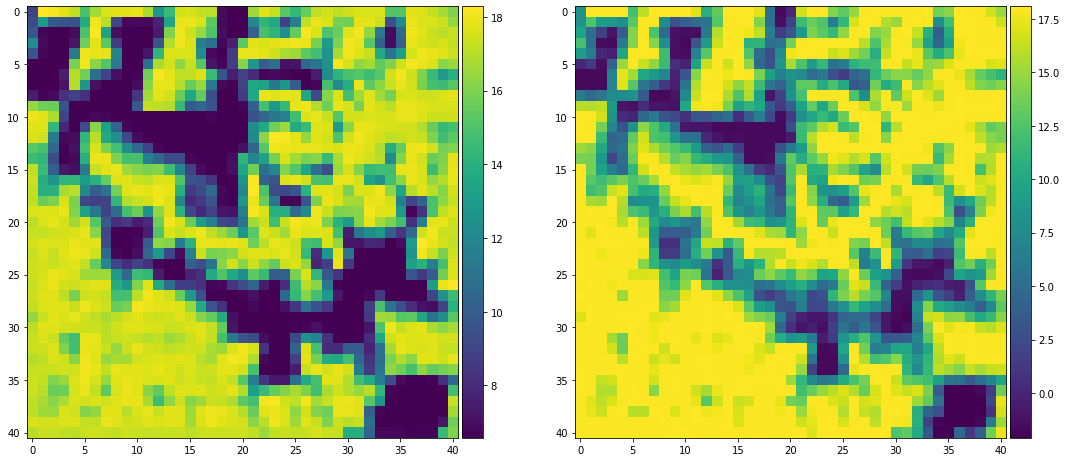

In [39]:
fig, axs = plt.subplots(1,2, figsize = (18, 18))

ax0 = axs[0]
im0 = ax0.imshow(result_denorm[0, 3, :, :, 40])
divider = make_axes_locatable(ax0)
cax = divider.append_axes('right', size = '5%', pad = 0.05)
fig.colorbar(im0, cax = cax, orientation = 'vertical')

ax1 = axs[1]
im1 = ax1.imshow(target_train[0, 3, :, :, 40])
divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size = '5%', pad = 0.05)
fig.colorbar(im1, cax = cax, orientation = 'vertical')

plt.show()

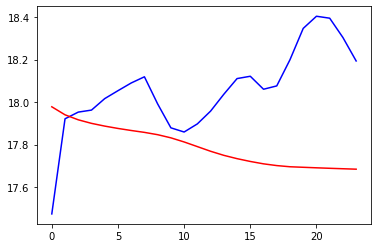

In [40]:
plt.plot(result_denorm[0, :, 14, 6, 40], 'b')
plt.plot(target_train[0, :, 14, 6, 40], 'r')
plt.show()